# Task 2.3 - Physics-augmented neural network model

## Setup

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from typing import Literal
from keras import optimizers
from keras import losses
from keras import metrics
from pprint import pprint

from src.models import InvariantsICNN
from src.data_import import load_paml_dataset, load_data
from src.plots import plot_stress_predictions, plot_loss, plot_heatmap
from src.utils import get_scores
from src.predict_utils import predict_multi_cases, predict_identity_F

2024-11-26 15:28:32.564367: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 15:28:32.570893: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 15:28:32.584702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 15:28:32.606879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 15:28:32.612980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 15:28:32.631273: I tensorflow/core/platform/cpu_feature_gu

### Paths

In [2]:
# Calibration paths
calibration_dir = os.path.abspath('calibration')
biaxial_path = os.path.join(calibration_dir, 'biaxial.txt')
pure_shear_path = os.path.join(calibration_dir, 'pure_shear.txt')
uniaxial_path = os.path.join(calibration_dir, 'uniaxial.txt')

# Test paths
test_dir = os.path.abspath('test')
biax_test_path = os.path.join(test_dir, 'biax_test.txt')
mixed_test_path = os.path.join(test_dir, 'mixed_test.txt')

### Load Datasets

In [3]:
biaxial_F, biaxial_P, biaxial_W = load_data(biaxial_path)
pure_shear_F, pure_shear_P, pure_shear_W = load_data(pure_shear_path)
uniaxial_F, uniaxial_P, uniaxial_W = load_data(uniaxial_path)

biax_test_F, biax_test_P, biax_test_W = load_data(biax_test_path)
mixed_test_F, mixed_test_P, mixed_test_W = load_data(mixed_test_path)

## PANN calibration on all stress Tensor $P$

In [ ]:
train_stress_features = tf.concat([biaxial_F, pure_shear_F, uniaxial_F], axis=0)
train_stress_labels = tf.concat([biaxial_P, pure_shear_P, uniaxial_P], axis=0)

In [ ]:
pann_stress_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_derivative=True
)
pann_stress_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_stress_h = pann_stress_model.fit(train_stress_features, train_stress_labels, batch_size=32, epochs=50, verbose=0)
pann_stress_loss = pann_stress_h.history['loss']
plot_loss(pann_stress_loss)

### Model Evaluation

#### -- predict on seen load cases

In [ ]:
stress_train_input_label_tup = {
    'biaxial': (biaxial_F, biaxial_P),
    'pure_shear': (pure_shear_F, pure_shear_P),
    'uniaxial': (uniaxial_F, uniaxial_P)
}

stress_labels, stress_preds = predict_multi_cases(pann_stress_model, stress_train_input_label_tup)
plot_stress_predictions(stress_labels, stress_preds)

#### -- predict on unseen load cases

In [ ]:
stress_test_input_label_tup = {
    'biaxial': (biax_test_F, biax_test_P),
    'mixed': (mixed_test_F, mixed_test_P),
}
stress_test_labels, stress_test_predictions = predict_multi_cases(pann_stress_model, stress_test_input_label_tup)
plot_stress_predictions(stress_test_labels, stress_test_predictions)

## Test $F=I$ for stress and energy

### PANN calibration on stress Tensor $P$

In [ ]:
predict_identity_F(pann_stress_model)

### PANN calibration on energy $W$

In [ ]:
train_energy_features = tf.concat([biaxial_F, pure_shear_F, uniaxial_F], axis=0)
train_energy_labels = tf.concat([biaxial_W, pure_shear_W, uniaxial_W], axis=0)

In [ ]:
pann_energy_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_derivative=False
)
pann_energy_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_energy_h = pann_energy_model.fit(train_energy_features, train_energy_labels, batch_size=32, epochs=50, verbose=0)
pann_energy_loss = pann_energy_h.history['loss']
plot_loss(pann_energy_loss)

In [ ]:
predict_identity_F(pann_energy_model)

## PANN calibration on stress $P$ and energy $W$

In [4]:
train_both_features = tf.concat([biaxial_F, pure_shear_F, uniaxial_F], axis=0)
train_both_labels = tf.concat([biaxial_W, pure_shear_W, uniaxial_W], axis=0)

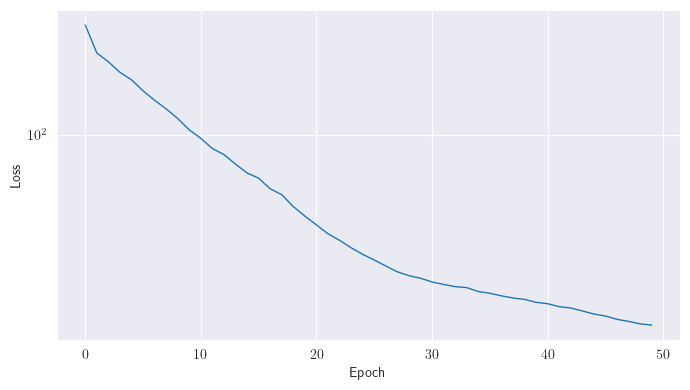

In [6]:
pann_both_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear'],
    use_output_and_derivative=True
)
pann_both_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
pann_energy_h = pann_both_model.fit(train_both_features, train_both_labels, batch_size=32, epochs=50, verbose=0)
pann_energy_loss = pann_energy_h.history['loss']
plot_loss(pann_energy_loss)

In [7]:
predict_identity_F(pann_both_model)

UnboundLocalError: cannot access local variable 'P_pred_eye' where it is not associated with a value

## Model calibration on one load case

In [ ]:
train_features = uniaxial_F
train_labels = uniaxial_P

In [ ]:
pann_stress_model = InvariantsICNN(
    hidden_sizes=[16, 1],
    activations=['softplus', 'linear']
)
pann_stress_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
h = pann_stress_model.fit(train_features, train_labels, batch_size=32, epochs=1000, verbose=0)
loss = h.history['loss']

In [ ]:
fig_stress_loss = plot_loss(loss)
fig_stress_loss.tight_layout()
plt.show()

### Model Evaluation

#### -- on seen load cases

In [ ]:
biaxial_predictions = pann_stress_model.predict(biaxial_F)
pure_shear_predictions = pann_stress_model.predict(pure_shear_F)
uniaxial_predictions = pann_stress_model.predict(uniaxial_F)

In [ ]:
labels = {
    'biaxial': biaxial_P.numpy().reshape((-1, 9)),
    'pure_shear': pure_shear_P.numpy().reshape((-1, 9)),
    'uniaxial': uniaxial_P.numpy().reshape((-1, 9)),
}
predictions = {
    'biaxial': biaxial_predictions.reshape((-1, 9)),
    'pure_shear': pure_shear_predictions.reshape((-1, 9)),
    'uniaxial': uniaxial_predictions.reshape((-1, 9)),
}
fig_train_pred = plot_stress_predictions(labels, predictions)
fig_train_pred.tight_layout()
plt.show()

#### -- on unseen load cases

In [ ]:
biax_test_preds = pann_stress_model.predict(biax_test_F)
mixed_test_preds = pann_stress_model.predict(mixed_test_F)

In [ ]:
test_labels = {
    'biaxial': biax_test_P.numpy().reshape((-1, 9)),
    'mixed': mixed_test_P.numpy().reshape((-1, 9)),
}
test_predictions = {
    'biaxial': biax_test_preds.reshape((-1, 9)),
    'mixed': mixed_test_preds.reshape((-1, 9)),
}
fig_test_pred = plot_stress_predictions(test_labels, test_predictions)
fig_test_pred.tight_layout()
plt.show()